# Authentication and Configuration

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
from google.colab import drive
import warnings
drive.mount('/gdrive', force_remount=True)
print("..")
!ls
print("..")
import os 
os.getcwd()
print("..")
%cd /gdrive/MyDrive/NLPcourse/FinalProject
print("..")
os.getcwd()
print("..")
!ls

Mounted at /gdrive
..
adc.json  sample_data
..
..
/gdrive/MyDrive/NLPcourse/FinalProject
..
..
chi2_pickle	Moives_TV_First1000.json  temp
Final		Moives_TV_First100K.json  Test1000.json
keras_model	__pycache__		  Vectorizer_pickle
keras_model.h5	sentiment_analysis.png	  wn_affect.py
lda_pickle.jl	stop_words_list.py


# importing Libs

In [ ]:
''' format: lib's name, usecase '''
import json  # loading json files
import re # cleaning data
import string # cleaning data 
import nltk  # cleaning data 
nltk.download('stopwords') # cleaning data 
stopwords = nltk.corpus.stopwords.words('english') # cleaining data 
nltk.download('punkt') # for tokennizer fucntion we need it
nltk.download('wordnet') # for lemmetizing we need this 

nltk.download('averaged_perceptron_tagger')# needed in textblob method
from nltk import PorterStemmer # stemming in cleaning part 
ps = PorterStemmer() # func for cleaning data
from textblob import TextBlob # unsuper sentiment analyzing 
## Perfect resource for checking textblob lib capability :
## https://textblob.readthedocs.io/en/dev/quickstart.html
## textblob vs vaderSent: https://www.youtube.com/watch?v=qTyj2R-wcks
!pip install vaderSentiment # another tool for sentiment analyzing. it's like textblob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd # for creating data frame
import numpy as np # for processing data 
import sys
#from nltk.corpus import stopwords, sentiwordnet as swn #temporary  commenting 
from nltk.stem import WordNetLemmatizer # lemmetizing 
from nltk import ngrams 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation #LDA
import collections
#from stop_words_list import stop_words_list
#from wn_affect import wn_affect 
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from stop_words_list import stop_words_list #In movie reviews we need these more stopword
from wn_affect import wn_affect # More stopwords 
import random # randomly selecting reviews for creaing testset
import pickle # saving models 
# Roozbeh added libraries
from sklearn.feature_selection import chi2
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest

# evaluation of LDA
!pip install pyLDAvis 
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# Preprocessing Data set
( uploading, cleaning, and creating dataframe)

In [ ]:
data = json.load(open('Moives_TV_First100K.json'))
# test = json.load(open('Test1000.json'))

numberOftrain = 50000 # How many data to train
numberOftest = 1000 # How many data to test

alldata_index = random.sample(range(len(data)), numberOftrain + numberOftest)
testdata_index = random.sample(alldata_index, numberOftest)

scores =[]
reviews = []
verified = []
vote = []
testScores = []
testReviews = []
testverified = []
testvote = []

for i in alldata_index:
  if data[i].__contains__('overall') and data[i].__contains__('reviewText') and data[i].__contains__('verified'):
    if i in testdata_index:
      testScores.append(int(data[i]['overall']))
      testReviews.append(data[i]['reviewText'])
      if data[i]['verified']:
        testverified.append(1)
      else:
        testverified.append(0)
      if data[i].__contains__('vote'):
        testvote.append(int(data[i]['vote'].replace(',', '')))
      else:
        testvote.append(1)
    
    else:
      scores.append(int(data[i]['overall']))
      reviews.append(data[i]['reviewText'])
      if data[i]['verified']:
        verified.append(1)
      else:
        verified.append(0)
      if data[i].__contains__('vote'):
        vote.append(int(data[i]['vote'].replace(',', '')))
      else:
        vote.append(1)


print('Size of train set: ', len(scores)) # Scores frequency is highly skewed
print('Size of test set: ', len(testScores))
scores_freq = {x:scores.count(x) for x in set(scores)}
print('Frequency of each rating in trainset: ', scores_freq)
scores_freq_test = {x:testScores.count(x) for x in set(testScores)}
print('Frequency of each rating in testset: ', scores_freq_test)

Size of train set:  49951
Size of test set:  998
Frequency of each rating in trainset:  {1: 2503, 2: 1540, 3: 3002, 4: 7568, 5: 35338}
Frequency of each rating in testset:  {1: 49, 2: 38, 3: 60, 4: 153, 5: 698}


In [ ]:
# Creating dataframe and fillind it
df = pd.DataFrame(reviews, columns =['reviews'])
display(df)

,reviews
0,Classic! I just had to have it in my collection!
1,.3WE have 8 children and have had lots of joy ...
2,Good Fiction
3,Jack Nicholson as Randle McMurphy who is sent ...
4,Excellent movie
...,...
49946,"Got it in a timely manner, as promised. Love ..."
49947,This movie had me going for a while. At first ...
49948,Cinderella is a classical movie that tells abo...
49949,A fantastic movie that explores not only the m...


In [ ]:
# Apply text cleaning techniques

def textCleaner(text):
    ''' removing all URLs '''
    text = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', text)
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    '''Get rid of some additional punctuation and non-sensical text that was missed the previous subroutines.'''
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', '', text)
    ''' Removing stop words '''
    tokens = text.split(" ")
    cleanedText = ""
    for token in tokens:
      if(token not in stopwords):
        cleanedText += (token + " ")
    text = cleanedText 
    ''' Stemming '''
    tokens = text.split(" ")
    cleanedText=""
    for tok in tokens:
      cleanedText += (ps.stem(tok) + " ")
    text = cleanedText


    return text

# cleaner = lambda x: textCleaning(x)

In [ ]:
print(textCleaner(reviews[0]))# frist review after cleaning

classic collect  


In [ ]:
#cleaning reviews
clean_reviews = []
for review in reviews:
  clean_reviews.append(textCleaner(review))
print(len(clean_reviews))

49951


In [ ]:
#updating dataframe 
df['cleaned_and_tokenised'] = clean_reviews
# case text as lowercase, remove punctuation, remove extra whitespace in string and on both sides of string
# further cleaning ### merge following proccess with the textCleaning fucn
df['cleaned_and_tokenised'] = df['cleaned_and_tokenised'].str.lower().str.replace("'", '').str.replace(r'[^\w\s]', ' ').str.replace(r" \d+", " ").str.replace(' +', ' ').str.strip()
df['cleaned_and_tokenised'] = df.apply(lambda row: nltk.word_tokenize(row[1]), axis=1) #  Row[1] is " removeLowerPunct "  column
wordnet_lemmatizer = WordNetLemmatizer() # initiate nltk lemmatiser
df['lemmatise'] = df['cleaned_and_tokenised'].apply(lambda x: [wordnet_lemmatizer.lemmatize(y) for y in x]) # lemmatise words
display(df)

,reviews,cleaned_and_tokenised,lemmatise
0,Classic! I just had to have it in my collection!,"[classic, collect]","[classic, collect]"
1,.3WE have 8 children and have had lots of joy ...,"[children, lot, joy, sing, along, time, grandc...","[child, lot, joy, sing, along, time, grandchil..."
2,Good Fiction,"[good, fiction]","[good, fiction]"
3,Jack Nicholson as Randle McMurphy who is sent ...,"[jack, nicholson, randl, mcmurphi, sent, menta...","[jack, nicholson, randl, mcmurphi, sent, menta..."
4,Excellent movie,"[excel, movi]","[excel, movi]"
...,...,...,...
49946,"Got it in a timely manner, as promised. Love ...","[got, time, manner, promis, love, movi]","[got, time, manner, promis, love, movi]"
49947,This movie had me going for a while. At first ...,"[movi, go, first, thought, would, base, acclai...","[movi, go, first, thought, would, base, acclai..."
49948,Cinderella is a classical movie that tells abo...,"[cinderella, classic, movi, tell, young, beaut...","[cinderella, classic, movi, tell, young, beaut..."
49949,A fantastic movie that explores not only the m...,"[fantast, movi, explor, moral, implic, gene, s...","[fantast, movi, explor, moral, implic, gene, s..."


In [ ]:
# count vectorizer 
# we need this for LDA model and maybe for DL method 

# initialise the count vectorizer
vectorizer = CountVectorizer(analyzer = 'word', ngram_range = (1, 2)) #(1,2): using both monogram and bigrams
# join the processed data to be vectorised
vectors = []
for index, row in df.iterrows():
    vectors.append(", ".join(row[2])) # lemmatize column
vectorised = vectorizer.fit_transform(vectors)

# Phase 1 , Unsupervised sentiment analysis

## Textblob method

### introduction


In [ ]:
TextBlob("realli happi got evangelis  spoiler alerthappi end like thatsinc start bit worrisom yeah great stori missionari movi ").sentiment
TextBlob("the price of BTC is increasing ").sentiment.polarity
print(TextBlob("the price of BTC is increasing ").tags)

## Using TextBlob functions on reviews 
''''important note: 'score' list means overall score of reviews in our dataset and score_textblob is estimated SENTIMENT scores of reviews by textblob func''' 
score_txtblob = [] # sentiment score results of Textblob lib (-1< score <+1)
label_txtblob = [] # Lable = negative, nuetral, positive
rate_txtblob_linear = [] # {1,2,3,4,5} using linear mapping 
rate_txtblob_nonlin = [] # {1,2,3,4,5} using non linear mapping 
ln = 0 #lenght

dataSet_ratings_freq = {x:scores.count(x) for x in set(scores)}
rate_txtblob_linear_freq = {} #{'1':0,'2':0,'3':0,'4':0,'5':0}
rate_txtblob_nonlin_freq = {} #{'1':0,'2':0,'3':0,'4':0,'5':0}

print("dataSet_ratings_freq:\n",dataSet_ratings_freq,"\nrate_txtblob_linear_freq:\n",rate_txtblob_linear_freq,"\nrate_txtblob_nonlin_freq:\n",rate_txtblob_nonlin_freq)

[('the', 'DT'), ('price', 'NN'), ('of', 'IN'), ('BTC', 'NNP'), ('is', 'VBZ'), ('increasing', 'VBG')]
dataSet_ratings_freq:
 {1: 2503, 2: 1540, 3: 3002, 4: 7568, 5: 35338} 
rate_txtblob_linear_freq:
 {} 
rate_txtblob_nonlin_freq:
 {}


### finding score with Textblob 

In [ ]:
print(len(reviews))

49951


In [ ]:
lll = len(reviews)
score_txtblob = [0]*lll
i=0
for review in reviews:
  score_txtblob[i]=round(TextBlob(review).sentiment.polarity, 3)
  i+=1

print(score_txtblob)
ln = len(score_txtblob)
print(ln)

[0.26, 0.7, 0.7, 0.209, 1.0, 0.781, 0.048, 0.8, 0.333, 0.229, 0.5, 0.2, 0.204, 0.133, 0.8, 0.466, 0.234, 0.0, 0.0, 0.5, -0.062, 0.0, 0.233, 0.324, 0.5, 0.303, 0.614, 0.35, 0.183, 0.5, 0.413, 0.616, 0.469, 0.8, 0.7, 0.204, 0.199, 0.483, 0.425, 0.249, 0.077, 0.8, 0.168, 0.667, 0.073, -0.022, 0.525, 0.303, 0.429, 0.5, 0.171, 0.167, 0.0, 0.0, 1.0, 0.253, 0.0, 0.301, 0.7, 0.467, 0.0, 0.292, -0.022, 0.293, 0.475, 0.175, 0.085, 0.5, -0.005, 0.525, 0.427, 0.001, 0.433, 0.8, 0.8, 1.0, 0.567, 0.8, 0.396, 0.594, -0.089, 0.01, 0.0, 0.048, 0.0, 0.29, 0.167, 0.25, 0.583, 0.2, 0.8, 0.333, 0.6, 0.138, 0.175, 0.8, 0.0, 0.501, 0.433, 0.6, 0.8, 0.202, 0.083, 0.588, 1.0, 1.0, 0.127, 0.8, -0.111, 0.7, 0.256, 0.076, 0.8, 0.0, -0.5, 0.0, 0.0, 0.5, 0.0, 0.8, 0.925, 0.011, 0.251, 0.118, 0.0, 0.451, 1.0, 0.028, 0.537, 0.4, 0.044, 0.5, -0.209, 0.221, 0.0, 0.167, 0.102, 0.733, 0.417, 0.283, -0.03, 0.567, 0.096, 0.5, 0.435, 0.472, 0.0, 0.25, 0.8, 0.206, 0.108, -0.018, 1.0, 0.8, 0.55, 0.7, 0.65, 0.8, 0.442, 0.531, 

### Finding lable with Textblob

In [ ]:
label_txtblob =[' ']*ln 
for i in range(ln):  
    if score_txtblob[i] >= 0.05:
        label_txtblob[i]= 'Positive'
    elif score_txtblob[i] > -0.05 and score_txtblob[i] < 0.05:
        label_txtblob[i]= 'Neutral'
    elif score_txtblob[i] <= -0.05:
        label_txtblob[i]= 'Negative'


In [ ]:
print(label_txtblob)

['Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Neutral', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Neutral', 'Neutral', 'Positive', 'Negative', 'Neutral', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Neutral', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Neutral', 'Neutral', 'Positive', 'Positive', 'Neutral', 'Positive', 'Positive', 'Positive', 'Neutral', 'Positive', 'Neutral', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Neutral', 'Positive', 'Positive', 'Neutral', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Negative', 'Neutral', 'Neutral', 'Neutral', 'Neutr

### Finding rating with Textblob

In [ ]:
rate_txtblob_linear =[0]*ln
rate_txtblob_nonlin =[0]*ln

# _____________ Linear mapping Scores: from [-1,1] to {1,2,3,4,5}____________#
f = lambda x: round((2*x)+3)
for i in range(ln):
  rate_txtblob_linear[i]= f(score_txtblob[i])
print("Linear mapping:\n",rate_txtblob_linear)

rate_txtblob_linear_freq = {x:rate_txtblob_linear.count(x) for x in set(rate_txtblob_linear)}
#NonLinear mapping Scores:from[-1,1]to{1,2,3,4,5}, with respect to scores frequency

## Developing better mapping with respect to the scores frequency :
print(dataSet_ratings_freq, type(dataSet_ratings_freq))
sq = dataSet_ratings_freq # remane
# supremum for category "score =1 "  : s1
s1 = round(( ( sq[1] / (sq[1]+sq[2]+ (sq[3]/2) ) )*2 + 1 ) ,3)         
fraction1 = [1,s1] # fraction for score number one 
s2 = round(( ( sq[2] / (sq[1]+sq[2]+ (sq[3]/2) ) )*2 + s1 ) ,3)
fraction2 = [s1,s2] # fraction for score number 2 
s3 = round(( ( (sq[3]/2) / (sq[5]+sq[4]+ (sq[3]/2) ) )*2 + 3 ) ,3)
fraction3 = [s2,s3] # fraction for score number 3 
s4 = round(( ( sq[4] / (sq[5]+sq[4]+ (sq[3]/2) ) )*2 + s3 ) ,3)
fraction4 = [s3,s4] # fraction for score number 4 
fraction5 = [s4,5] # fraction for score number 5 

def nonLinearMap(score):
  if (fraction1[0]<= score <= fraction1[1]):
    return 1
  if (fraction2[0] < score <= fraction2[1]):
    return 2
  if (fraction3[0] < score <= fraction3[1]):
    return 3
  if (fraction4[0] < score <= fraction4[1]):
    return 4
  if (fraction5[0] < score <= fraction5[1]):
    return 5
  return -1 # error

for i in range(ln):
  rate_txtblob_nonlin[i]= nonLinearMap((2*score_txtblob[i]+3))

rate_txtblob_nonlin_freq = {x:rate_txtblob_nonlin.count(x) for x in set(rate_txtblob_nonlin)}


print("dataSet_ratings_freq:\n",dataSet_ratings_freq,"\nrate_txtblob_linear_freq:\n",rate_txtblob_linear_freq,"\nrate_txtblob_nonlin_freq:\n",rate_txtblob_nonlin_freq)

Linear mapping:
 [4, 4, 4, 3, 5, 5, 3, 5, 4, 3, 4, 3, 3, 3, 5, 4, 3, 3, 3, 4, 3, 3, 3, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 5, 4, 3, 3, 4, 4, 3, 3, 5, 3, 4, 3, 3, 4, 4, 4, 4, 3, 3, 3, 3, 5, 4, 3, 4, 4, 4, 3, 4, 3, 4, 4, 3, 3, 4, 3, 4, 4, 3, 4, 5, 5, 5, 4, 5, 4, 4, 3, 3, 3, 3, 3, 4, 3, 4, 4, 3, 5, 4, 4, 3, 3, 5, 3, 4, 4, 4, 5, 3, 3, 4, 5, 5, 3, 5, 3, 4, 4, 3, 5, 3, 2, 3, 3, 4, 3, 5, 5, 3, 4, 3, 3, 4, 5, 3, 4, 4, 3, 4, 3, 3, 3, 3, 3, 4, 4, 4, 3, 4, 3, 4, 4, 4, 3, 4, 5, 3, 3, 3, 5, 5, 4, 4, 4, 5, 4, 4, 3, 3, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 4, 3, 4, 3, 4, 4, 4, 4, 5, 4, 3, 4, 4, 4, 4, 3, 4, 3, 3, 4, 4, 3, 4, 4, 3, 4, 3, 4, 4, 4, 4, 4, 4, 3, 4, 3, 3, 4, 3, 4, 4, 3, 4, 5, 4, 4, 2, 4, 4, 5, 4, 4, 3, 4, 5, 3, 4, 4, 2, 4, 5, 3, 4, 3, 5, 4, 3, 3, 4, 4, 5, 5, 3, 4, 3, 3, 4, 4, 2, 4, 4, 3, 3, 4, 4, 3, 5, 3, 3, 5, 3, 5, 3, 4, 3, 4, 4, 5, 3, 3, 4, 3, 4, 4, 5, 4, 4, 5, 3, 3, 5, 4, 3, 3, 3, 4, 3, 5, 3, 5, 4, 4, 4, 3, 4, 4, 3, 3, 3, 4, 4, 4, 5, 4, 4, 3, 3, 3, 4, 3, 3, 3, 4, 4, 3, 4, 4, 4

### updating data frame

In [ ]:
df['Sentiment_score_txtblob'] = score_txtblob
df['label_txtblob'] = label_txtblob
df['rate_txtblob_linear'] = rate_txtblob_linear
df['rate_txtblob_nonlin'] = rate_txtblob_nonlin
display(df)

,reviews,cleaned_and_tokenised,lemmatise,Sentiment_score_txtblob,label_txtblob,rate_txtblob_linear,rate_txtblob_nonlin
0,Classic! I just had to have it in my collection!,"[classic, collect]","[classic, collect]",0.260,Positive,4,5
1,.3WE have 8 children and have had lots of joy ...,"[children, lot, joy, sing, along, time, grandc...","[child, lot, joy, sing, along, time, grandchil...",0.700,Positive,4,5
2,Good Fiction,"[good, fiction]","[good, fiction]",0.700,Positive,4,5
3,Jack Nicholson as Randle McMurphy who is sent ...,"[jack, nicholson, randl, mcmurphi, sent, menta...","[jack, nicholson, randl, mcmurphi, sent, menta...",0.209,Positive,3,5
4,Excellent movie,"[excel, movi]","[excel, movi]",1.000,Positive,5,5
...,...,...,...,...,...,...,...
49946,"Got it in a timely manner, as promised. Love ...","[got, time, manner, promis, love, movi]","[got, time, manner, promis, love, movi]",0.500,Positive,4,5
49947,This movie had me going for a while. At first ...,"[movi, go, first, thought, would, base, acclai...","[movi, go, first, thought, would, base, acclai...",-0.075,Negative,3,3
49948,Cinderella is a classical movie that tells abo...,"[cinderella, classic, movi, tell, young, beaut...","[cinderella, classic, movi, tell, young, beaut...",0.360,Positive,4,5
49949,A fantastic movie that explores not only the m...,"[fantast, movi, explor, moral, implic, gene, s...","[fantast, movi, explor, moral, implic, gene, s...",0.133,Positive,3,4


# chi square

In [ ]:
chi2_selector = SelectKBest(chi2, k=2000)
chi2_vectorized = chi2_selector.fit_transform(vectorised, scores)

In [ ]:
# Look at scores returned from the selector for each feature
chi2_scores = pd.DataFrame(list(zip(vectorizer.get_feature_names(), chi2_selector.scores_, chi2_selector.pvalues_)), columns=['ftr', 'score', 'pval'])
print(chi2_scores)

# you can see that the kbest returned from SelectKBest 
#+ were the two features with the _highest_ score
kbest = np.asarray(vectorizer.get_feature_names())[chi2_selector.get_support()]
print(kbest)

                 ftr      score      pval
0                 aa   4.676208  0.322162
1          aa appeal  31.435714  0.000002
2          aa doesnt   0.413521  0.981355
3         aa fontain   5.600291  0.231053
4             aa kid  18.956452  0.000802
...              ...        ...       ...
922586            zz   1.240563  0.871376
922587        zz top   1.240563  0.871376
922588         zztop  31.435714  0.000002
922589     zztop low  31.435714  0.000002
922590  zzzzzzzzzzzz  18.956452  0.000802

[922591 rows x 3 columns]
['abomin' 'absolut noth' 'absolut worst' ... 'zombi horror' 'zombi movi'
 'zombi wander']


## DL method

Constructing X_train and Y_train

In [ ]:
X_train = np.concatenate((chi2_vectorized.toarray(), np.array([verified]).T, np.array([vote]).T), axis=1)
Y_train = np.array(scores)

Importing libraries and initializing parameters

In [ ]:
from keras.layers import Dense, Embedding, Conv1D, GlobalMaxPooling1D
from keras.models import Sequential
from keras.utils import to_categorical
from sklearn.utils import class_weight
from sklearn.metrics import classification_report

In [ ]:
batch_size = 64
embedding_dims = 16
filters = 128
kernel_size = 3
epochs = 5
max_features, maxlen = X_train.shape


class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(scores),
                                                 scores)
class_weights = {0: 0, 1: class_weights[0], 2: class_weights[1], 3: class_weights[2], 4:class_weights[3], 5: class_weights[4]}

print(max_features, maxlen)
print(Y_train.shape[0])
print(class_weights)

49951 2002
49951
{0: 0, 1: 3.99129045145825, 2: 6.4871428571428575, 3: 3.3278481012658228, 4: 1.3200581395348838, 5: 0.282704171147207}


training model

In [ ]:
model = Sequential()
model.add(Embedding(max_features, embedding_dims, input_length=maxlen))
model.add(Conv1D(filters, kernel_size, padding='valid', activation='relu', strides=1))
model.add(GlobalMaxPooling1D())
model.add(Dense(128,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(6, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, class_weight=class_weights)

Epoch 1/5
781/781 [==============================] - 189s 241ms/step - loss: 1.6156 - acc: 0.2343
Epoch 2/5
781/781 [==============================] - 190s 243ms/step - loss: 1.5836 - acc: 0.4629
Epoch 3/5
781/781 [==============================] - 191s 245ms/step - loss: 1.5675 - acc: 0.4948
Epoch 4/5
781/781 [==============================] - 191s 244ms/step - loss: 1.5526 - acc: 0.4992
Epoch 5/5
781/781 [==============================] - 184s 235ms/step - loss: 1.5709 - acc: 0.4972


evaluation

In [ ]:
y_pred = model.predict(X_train, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(Y_train, y_pred_bool))

781/781 [==============================] - 41s 52ms/step
              precision    recall  f1-score   support

           1       0.16      0.35      0.22      2503
           2       0.06      0.29      0.09      1540
           3       0.10      0.14      0.12      3002
           4       0.19      0.04      0.06      7568
           5       0.77      0.67      0.72     35338

    accuracy                           0.52     49951
   macro avg       0.26      0.30      0.24     49951
weighted avg       0.59      0.52      0.54     49951



Test

In [ ]:
test_clean_reviews = []
for review in testReviews:
  test_clean_reviews.append(textCleaner(review))

In [ ]:
test_df = pd.DataFrame(test_clean_reviews, columns =['remove_lower_punct'])

# tokenise string
test_df['tokenise'] = test_df.apply(lambda row: nltk.word_tokenize(row[0]), axis=1) #  Row[1] is " removeLowerPunct "  column 

# remove stopwords
test_df['remove_stopwords'] = test_df['tokenise'].apply(lambda x: [item for item in x if item not in stopwords])


# initiate nltk lemmatiser
wordnet_lemmatizer = WordNetLemmatizer()

# lemmatise words
test_df['lemmatise'] = test_df['remove_stopwords'].apply(lambda x: [wordnet_lemmatizer.lemmatize(y) for y in x])

# join the processed data to be vectorised
test_vectors = []

for index, row in test_df.iterrows():
    # vectors.append(", ".join(row[6]))
    test_vectors.append(" ".join(row[3])) # lemmatise
# print(vectors)
test_vectorised = vectorizer.transform(test_vectors)

In [ ]:
test_chi2_vectorized = chi2_selector.transform(test_vectorised)

In [ ]:
print(test_chi2_vectorized.toarray().shape)
print(len(test_clean_reviews))
print(len(test_vectors))
# display(test_df)

(998, 2000)
998
998


In [ ]:
X_test = np.concatenate((test_chi2_vectorized.toarray(), np.array([testverified]).T, np.array([testvote]).T), axis=1)
testScores = np.array(testScores)
Y_test = testScores

In [ ]:
y_pred_test = model.predict(X_test, batch_size=64, verbose=1)
y_pred_bool_test = np.argmax(y_pred_test, axis=1)

print(classification_report(Y_test, y_pred_bool_test))

16/16 [==============================] - 1s 51ms/step
              precision    recall  f1-score   support

           1       0.14      0.31      0.19        49
           2       0.05      0.21      0.08        38
           3       0.12      0.20      0.15        60
           4       0.22      0.05      0.08       153
           5       0.76      0.66      0.70       698

    accuracy                           0.50       998
   macro avg       0.26      0.28      0.24       998
weighted avg       0.58      0.50      0.53       998



In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2002, 16)          799216    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2000, 128)         6272      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 390       
Total params: 830,646
Trainable params: 830,646
Non-trainable params: 0
________________________________________________

Saving vectorizer, chi2, and Keras model

In [ ]:
with open('Vectorizer_pickle', 'wb') as fout:
    pickle.dump((vectorizer), fout)

with open('chi2_pickle', 'wb') as fout:
    pickle.dump((chi2_selector), fout)

model.save('keras_model.h5')

function for handeling input text

In [ ]:
def DL_predict(text, r_vote, r_verified):
  r_clean_reviews = [textCleaner(text)]
  print(r_clean_reviews)

  r_df = pd.DataFrame(r_clean_reviews, columns =['remove_lower_punct'])

  # tokenise string
  r_df['tokenise'] = r_df.apply(lambda row: nltk.word_tokenize(row[0]), axis=1) #  Row[1] is " removeLowerPunct "  column 

  # remove stopwords
  r_df['remove_stopwords'] = r_df['tokenise'].apply(lambda x: [item for item in x if item not in stopwords])


  # initiate nltk lemmatiser
  wordnet_lemmatizer = WordNetLemmatizer()

  # lemmatise words
  r_df['lemmatise'] = r_df['remove_stopwords'].apply(lambda x: [wordnet_lemmatizer.lemmatize(y) for y in x])

  # join the processed data to be vectorised
  r_vectors = []

  for index, row in r_df.iterrows():
    # vectors.append(", ".join(row[6]))
    r_vectors.append(" ".join(row[3])) # lemmatise
  # print(vectors)
  r_vectorised = vectorizer.transform(r_vectors)

  r_chi2_vectorized = chi2_selector.transform(r_vectorised)

  X_r = np.concatenate((r_chi2_vectorized.toarray(), np.array([[r_verified]]).T, np.array([[r_vote]]).T), axis=1)

  y_pred_r = model.predict(X_r, batch_size=64, verbose=1)
  y_pred_bool_r = np.argmax(y_pred_r, axis=1)
  
  return y_pred_bool_r[0]

In [ ]:
ttt = "really happy they got evangelised .. spoiler alert==happy ending liked that..since started bit worrisome... but yeah great stories these missionary movies"
print(DL_predict(ttt, 1, 1))

['realli happi got evangelis  spoiler alerthappi end like thatsinc start bit worrisom yeah great stori missionari movi  ']
1/1 [==============================] - 0s 12ms/step
5


# Phase 2 , Topic modeling 

## intro

In [ ]:
# In terminology of NLP, An opinion could be defined 
# as a combination of four factors (entity, holder, claim, and sentiment)
# We already knwo that Reviews belong to costumers, so Holder = costumer 
# In P1 we developed an appraoch for "sentiment" = textblob("").sentiment
# In Phase to we wanna find "entity" 
# (And try to extract cliam for more actionable insights from reviews)

# In NLP terminology "entity" called "topic modeling or aspect-finding"

## LDA model 

In [ ]:
# initisalise LDA Model

lda_model = LatentDirichletAllocation(n_components = 10, # number of topics
                                  random_state = 10,          # random state
                                  evaluate_every = -1,      # compute perplexity every n iters, default: Don't
                                  n_jobs = -1,              # Use all available CPUs
                                 )

lda_output = lda_model.fit_transform(vectorised) ## It determines 5 topic and 
## ... show how much each document is probable 

## print(lda_output)
# column names

topic_names = [i for i in range(1, lda_model.n_components + 1)]
print(topic_names)
# make the pandas dataframe

df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns = topic_names)

# get dominant topic for each document

dominant_topic = (np.argmax(df_document_topic.values, axis=1)+1)
df_document_topic['Dominant_topic'] = dominant_topic

# join to original dataframes

df = pd.merge(df, df_document_topic, left_index = True, right_index = True, how = 'outer')


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In [ ]:
display(df.head(10))

,reviews,cleaned_and_tokenised,lemmatise,Sentiment_score_txtblob,label_txtblob,rate_txtblob_linear,rate_txtblob_nonlin,sentiment_label_vadLib,sentiment score,1,2,3,4,5,6,7,8,9,10,Dominant_topic
0,"Love this DVD, music from the movie by the sam...","[love, dvd, music, movi, name, also, love, mov...","[love, dvd, music, movi, name, also, love, mov...",0.250,Positive,4,5,Neutral,0.0,0.86,0.10,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1
1,"<a data-hook=""product-link-linked"" class=""a-li...","[datahookproductlinklink, classalinknorm, fun,...","[datahookproductlinklink, classalinknorm, fun,...",0.650,Positive,4,5,Neutral,0.0,0.27,0.00,0.71,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3
2,Classic and suspenseful. You can't miss this ...,"[classic, suspens, cant, miss, one, rememb, lo...","[classic, suspens, cant, miss, one, rememb, lo...",0.083,Positive,3,4,Neutral,0.0,0.33,0.01,0.33,0.01,0.01,0.29,0.01,0.01,0.01,0.01,1
3,Wow! Has it really been 40 years? Ni! Loads...,"[wow, realli, year, ni, load, fun, love, extra]","[wow, realli, year, ni, load, fun, love, extra]",0.294,Positive,4,5,Neutral,0.0,0.50,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.45,0.01,1
4,Good movie. Good plot. Good acting. Good casting.,"[good, movi, good, plot, good, act, good, cast]","[good, movi, good, plot, good, act, good, cast]",0.560,Positive,4,5,Neutral,0.0,0.94,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,1
5,Great movie as it tells the story of the cross...,"[great, movi, tell, stori, cross, delawar, riv...","[great, movi, tell, stori, cross, delawar, riv...",0.300,Positive,4,5,Neutral,0.0,0.68,0.00,0.00,0.00,0.00,0.29,0.00,0.00,0.00,0.00,1
6,"Good acting by Bale and some memorable lines, ...","[good, act, bale, memor, line, wouldnt, see]","[good, act, bale, memor, line, wouldnt, see]",0.400,Positive,4,5,Neutral,0.0,0.28,0.66,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,2
7,beautiful nature - the movie is just ok - woul...,"[beauti, natur, movi, ok, wouldnt, recommend, ...","[beauti, natur, movi, ok, wouldnt, recommend, ...",0.160,Positive,3,4,Neutral,0.0,0.58,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.38,0.00,1
8,Packed well and happily received.,"[pack, well, happili, receiv]","[pack, well, happili, receiv]",0.800,Positive,5,5,Neutral,0.0,0.01,0.01,0.01,0.89,0.01,0.01,0.01,0.01,0.01,0.01,4
9,I am not reviewing the film but the disc itsel...,"[review, film, disc, itselfthi, one, worst, tr...","[review, film, disc, itselfthi, one, worst, tr...",-0.024,Neutral,3,3,Neutral,0.0,0.41,0.00,0.00,0.00,0.00,0.05,0.00,0.53,0.00,0.00,8


### subsection for LDA 

In [ ]:
# index names
datatemp = data[:len(scores)] ##
docnames = ['Doc' + str(i) for i in range(len(datatemp))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topic_names, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topic_names

df_topic_no = pd.DataFrame(df_topic_keywords.idxmax())
df_scores = pd.DataFrame(df_topic_keywords.max())

tmp = pd.merge(df_topic_no, df_scores, left_index=True, right_index=True)
#print(df_topic_no)
tmp.columns = ['topic', 'relevance_score']

display(tmp) # 924693 is total number of unique words 

,topic,relevance_score
aa,3,1.100016
aa doesnt,3,1.099994
aa teacher,6,1.099983
aaa,4,7.099849
aaa fast,10,1.099799
...,...,...
zygot birth,4,1.100000
zz,6,1.100000
zz top,6,1.100000
zzz,10,1.100000


In [ ]:
all_topics = []

for i in tmp['topic'].unique(): # i ={topic1, topic2, Topic3, Topic4, Topica5} 
    tmp_1 = tmp.loc[tmp['topic'] == i].reset_index()
    #print(tmp_1)
    tmp_1 = tmp_1.sort_values('relevance_score', ascending=False).head(1) #remove "head(1)" and see the result again
    #print(tmp_1)

    ## what is tmp_1
    #print(tmp_1)

    #tmp_1['topic'] = tmp_1['topic'] # removing  
    #print(tmp_1)


    tmp_2 = []
    tmp_2.append(tmp_1['topic'].unique()[0])
    tmp_2.append(list(tmp_1['index'].unique()))
    all_topics.append(tmp_2)


all_topics = pd.DataFrame(all_topics, columns=['Dominant_topic', 'topic_name'])
display(all_topics)

,Dominant_topic,topic_name
0,3,[film]
1,6,[apollo]
2,4,[georg]
3,10,[seem]
4,1,[movi]
5,2,[bale]
6,7,[vincent]
7,9,[horror]
8,8,[game]
9,5,[mose]


# Evaluation and visuallization 

## Sentiment-topic vis

In [ ]:
results = df.groupby(['Dominant_topic', 'rate_txtblob_nonlin']).count().reset_index()

results = results.merge(all_topics, on='Dominant_topic')
results['topic_name'] = results['topic_name'].apply(', '.join)

graph_results = results[['topic_name', 'rate_txtblob_nonlin', 'Sentiment_score_txtblob']]
graph_results = graph_results.pivot(index='topic_name', columns='rate_txtblob_nonlin', values='Sentiment_score_txtblob').reset_index()

graph_results.set_index('topic_name', inplace=True)

display(graph_results)

rate_txtblob_nonlin,1,2,3,4,5
topic_name,,,,,
apollo,33,86,594,810,1497
bale,42,57,533,773,1161
film,31,54,560,964,1567
game,27,63,571,822,1047
georg,25,32,402,693,1024
horror,16,40,408,749,1266
mose,29,54,385,474,654
movi,107,217,2599,3474,22957
seem,14,42,368,647,706


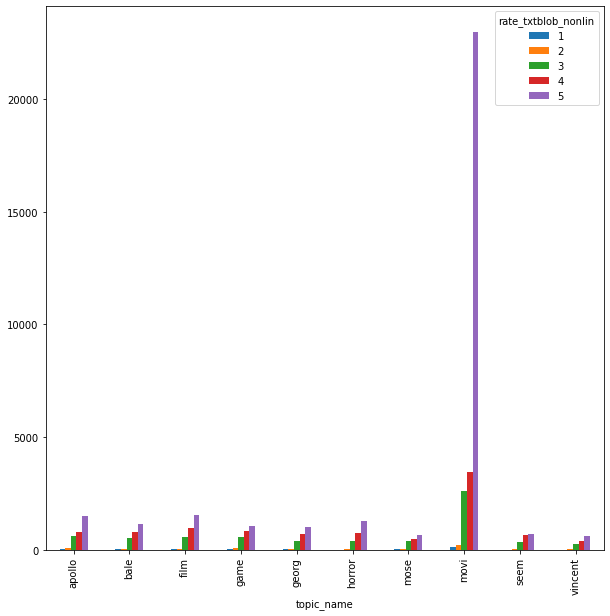

In [ ]:
fig = graph_results.plot.bar(rot=90, figsize=(10,10))
fig.figure.savefig('sentiment_analysis.png', bbox_inches='tight')

## LDA evaluation and visualization

In [ ]:
pyLDAvis.sklearn.prepare(lda_model, vectorised , vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.188503  0.019989       1        1  26.559327
2      0.023281 -0.029710       2        1  12.414913
1     -0.010197 -0.061176       3        1   9.279716
5      0.011776  0.070398       4        1   9.269840
7     -0.001694  0.017298       5        1   9.090159
8     -0.017428 -0.027460       6        1   9.057240
3     -0.009812 -0.039181       7        1   8.621063
9     -0.027532 -0.039820       8        1   7.128102
4     -0.068554  0.073882       9        1   4.407280
6     -0.088343  0.015781      10        1   4.172360, topic_info=              Term          Freq         Total Category  logprob  loglift
532314        movi  42375.000000  42375.000000  Default  30.0000  30.0000
355107       great  13621.000000  13621.000000  Default  29.0000  29.0000
484295        love  11763.000000  11763.000000  Default  28.0000  28.0000
356356  great movi   3133.000000   3133.000000  Default  27.0000  27.0000
485574   love movi   2708.000000   2708.000000  Default  26.0000  26.0000
...            ...           ...           ...      ...      ...      ...
820235       think     90.478751   3634.124948  Topic10  -7.3169  -0.5163
335955         get    100.052264   5890.497732  Topic10  -7.2163  -0.8987
497812        mani     88.536900   3593.126259  Topic10  -7.3385  -0.5267
917036       would     93.521703   5243.624923  Topic10  -7.2838  -0.8499
532314        movi    114.630262  42375.542681  Topic10  -7.0803  -2.7359

[976 rows x 6 columns], token_table=        Topic      Freq          Term
term                                 
1174        8  0.832213  abound flick
2423        4  0.912323   academybest
5343        1  0.524174           act
5343        2  0.107316           act
5343        3  0.070717           act
...       ...       ...           ...
928918      7  0.056028   zombi flick
928918      9  0.056028   zombi flick
928959      6  0.942133  zombi island
929363      7  0.904433          zuzu
929363     10  0.113054          zuzu

[3147 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2, 6, 8, 9, 4, 10, 5, 7])

## Textblob evaluation and visualization

### Textblob vis

In [ ]:
# we are going to evaluate overall performance of Textblob library:
# re naming :
init_ratings = scores
labels = label_txtblob  # Lable = negative, nuetral, positive
#rate_txtblob_linear  # {1,2,3,4,5} using linear mapping 
#rate_txtblob_nonlin
#print(init_ratings)

N = len(scores) # totla number of reviews 

def evaluator(init, labels):
  corrects=0
  lenght = len(init)
  if(lenght!=len(labels)):
    return -1
  for i in range(lenght):
    if( (init[i]==5 or init[i]==4) and (labels[i]=='Positive')  ):
      corrects+=1
    elif( ( init[i]==3 ) and (labels[i]=='Neutral')  ):
      corrects+=1
    elif( (init[i]==1 or init[i]==2) and (labels[i]=='Negative')  ):
      corrects+=1 
  return corrects

def evaluator_rating(init, labels): 
  corrects=0
  lenght = len(init)
  if(lenght!=len(labels)):
    return -1
  for i in range(lenght):
    if labels[i]==init[i]:
      corrects+=1
  return corrects


In [ ]:
correctNumber = evaluator(init_ratings,labels)
OverllAccuracyTextblob = round((correctNumber/N),5)
print(OverllAccuracyTextblob)

0.79887


In [ ]:
correctNumber_rating = evaluator_rating(init_ratings,rate_txtblob_nonlin)
OverllAccuracyTextblob_rating = round((correctNumber_rating/N),5)
print(OverllAccuracyTextblob_rating)

0.58178
